Use SocialGNN_encoding_2 environment

In [14]:
import os
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeCV, Ridge, LinearRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
model_selections = ['LSTM', 'SocialGNN', 'LSTM_Relation']
layer_selections = ['final_state', 'final_state', 'final_state']

model_encoding_dir = f'Data/layer_representations/'

In [16]:
target_ratings_dir = 'Data/behavioral_ratings.csv'
ratings_of_interest =['spatial expanse', 'object directed','interagent distance', 'agents facing', 'communication',  'joint action', 'valence', 'arousal']

In [17]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pickled = pickle.load(f)
    return pickled

In [18]:
ratings_df = pd.read_csv(target_ratings_dir)[['video_name'] + ratings_of_interest]
ratings_df_sorted = ratings_df.sort_values(by='video_name')

In [19]:
train_video_names = pd.read_csv('Data/train.csv')
test_video_names = pd.read_csv('Data/test.csv')

train_idx = ratings_df_sorted[ratings_df_sorted['video_name'].isin(train_video_names['video_name'])].index.tolist()
test_idx = ratings_df_sorted[ratings_df_sorted['video_name'].isin(test_video_names['video_name'])].index.tolist()
# Print the matching indices
print(train_idx, test_idx)

[0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 47, 49, 50, 51, 52, 54, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 91, 92, 94, 95, 96, 97, 99, 100, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 135, 136, 137, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 152, 154, 155, 156, 157, 158, 159, 160, 162, 164, 165, 166, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 186, 187, 188, 189, 190, 191, 194, 195, 196, 197, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249] [3, 6, 17, 21, 25, 26, 28, 37, 42, 46, 48, 53, 55, 56, 60, 61, 75, 83, 84, 88, 89, 

In [20]:
ratings_df_sorted

,video_name,spatial expanse,object directed,interagent distance,agents facing,communication,joint action,valence,arousal
0,-YwZOeyAQC8_15.mp4,0.225,0.895833,0.000000,0.045455,0.550000,0.700000,0.650000,0.340909
1,1AIVH5cEWrI_35.mp4,0.250,0.104167,0.075000,1.000000,0.900000,0.825000,0.675000,0.340909
2,2-8-0-2-5-4-8-8-5028025488_7.mp4,0.275,1.000000,0.045455,0.050000,0.500000,0.575000,0.675000,0.075000
3,3PJaYWt0cws_5.mp4,0.625,1.000000,0.725000,0.340909,0.150000,0.022727,0.600000,0.400000
4,7-5-1-0-3-6-9-8-3775103698_9.mp4,0.275,0.925000,0.275000,0.636364,0.825000,0.750000,0.722222,0.125000
...,...,...,...,...,...,...,...,...,...
245,yt-ylWmBeCU2LE_101.mp4,0.225,0.925000,0.250000,0.975000,0.840909,0.525000,0.800000,0.425000
246,yt-zGPMQDq1VdU_39.mp4,0.125,0.825000,0.150000,0.100000,0.750000,0.600000,0.650000,0.575000
247,yt-zcz5nb7m-Y4_55.mp4,0.050,0.975000,0.050000,1.000000,0.750000,0.825000,0.850000,0.400000
248,yt_R-62JchDNyM7U_143.mp4,0.500,1.000000,0.575000,0.275000,0.175000,0.590909,0.425000,0.250000


In [21]:
''' Function for you to test out the encoding results of a single layer from a selected model
    Input: X - a numpy array of loaded pickle file (n_samples=250, n_features)
    Example Usage: 
    model_features = load_pickle('Data/layer_representations/SocialGNN/final_state/GazeDataset_Jun1523_traintest5Jun23_2_0_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01')
    X = np.vstack(model_features)
'''

def single_layer_encoding(X):
    results = {}
    for rating in ratings_of_interest:
        y = ratings_df_sorted[rating].values
    
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        # Initialize the Ridge regression model
        ridge = Ridge(alpha=1.0)
    
        # Fit the model on the training data
        ridge.fit(X_train, y_train)
    
        # Predict on the test data
        y_pred = ridge.predict(X_test)
    
        # Calculate Mean Squared Error
        mse = mean_squared_error(y_test, y_pred)
        results[rating] = mse
        print(f'Mean Squared Error for {rating}: {mse}')

In [22]:
def regression_benchmarking(target, layers, models_classes, method='least square',
                            n_splits=4, random_seed=0, alphas=None):
    if alphas is None:
        alphas = np.logspace(-2, 5, 7)
    
    all_model_results = []
    
    # Iterate over each target rating separately
    for target_idx in tqdm(range(target.shape[1])):  # Assuming target is a 2D array
        current_target = target[:, target_idx]
        
        # Extract layer representations using TensorFlow
        for i, model_class in enumerate(models_classes):
            trained_model_path = os.path.join(model_encoding_dir, model_class, layers[i])
            for model_name in os.listdir(trained_model_path):
                model_path = os.path.join(trained_model_path, model_name)
                layer_representation = np.vstack(load_pickle(model_path))                
                
                # Flatten the representation if necessary
                X = layer_representation.reshape(layer_representation.shape[0], -1)
                # Separate data into train and test sets
                # Assuming X_train, X_test, y_train, y_test are predefined
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = current_target[train_idx], current_target[test_idx]
                
                
                if method == 'ridge':
                    # Initialize KFold
                    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

                    # Initialize RidgeCV model
                    ridge = RidgeCV(alphas=alphas)
    
                    # Fit the model on the training set
                    ridge.fit(X_train, y_train)
    
                    # Predict on the test set
                    y_test_pred = ridge.predict(X_test)
    
                    # Calculate the Pearson correlation for test set
                    test_score = pearsonr(y_test, y_test_pred)[0]
                    
                elif method == 'least square':
                    # Initialize LinearRegression model
                    lin_reg = LinearRegression()
                    
                    # Fit the model on the training set
                    lin_reg.fit(X_train, y_train)
                    
                    # Predict on the test set
                    y_test_pred = lin_reg.predict(X_test)
                    
                    # Calculate the Pearson correlation for test set
                    test_score = pearsonr(y_test, y_test_pred)[0]
                
                # Store results for this target
                all_model_results.append({
                    'feature': ratings_of_interest[target_idx],
                    'test_score': test_score,
                    'layer': layers[i],
                    'model_name': model_name,
                    'model_class': model_class
                })

                # Memory cleanup
                gc.collect()


    return pd.DataFrame(all_model_results)


In [23]:
target = ratings_df_sorted[ratings_of_interest].values

In [24]:
ridge_results = regression_benchmarking(target, layer_selections, model_selections, method = 'ridge')
linear_results = regression_benchmarking(target, layer_selections, model_selections, method = 'least square')

100%|██████████| 8/8 [01:00<00:00,  7.59s/it]


In [25]:
x_labels = ['spatial expanse', 'object directed', 'interagent distance', 'agents facing', 'communicating', 'acting jointly', 'valence', 'arousal']


# Assuming 'results_df' is the DataFrame returned by ridge_regression_benchmarking function
def plot_mapping_results(results_df, title):
    _, ax = plt.subplots(figsize=(10,5))
    sns.stripplot(x='feature', y='test_score', hue='model_class', data=results_df,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
    strip_collections = ax.collections
    sns.pointplot(x='feature', y='test_score', hue='model_class', data=results_df,
                   dodge=.55, linestyle="none", errorbar=None,
                  marker="_", markersize=14, markeredgewidth=3, zorder=1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=25, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Score ($r$)')
    ax.set_ylim([-0.25, 1])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              ncol=1, fancybox=True)
    plt.tight_layout()
    plt.savefig(f'result_figures/behavioral_encoding/{title}.png')
    plt.show()

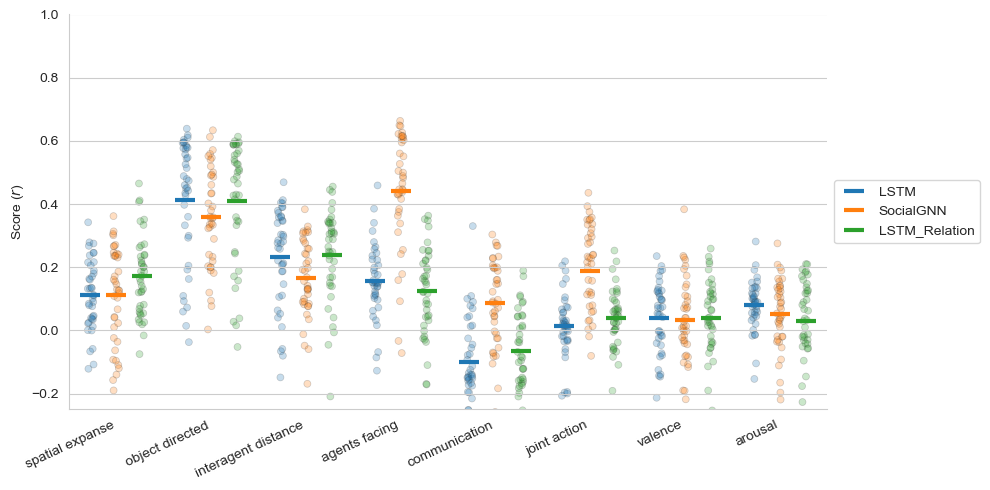

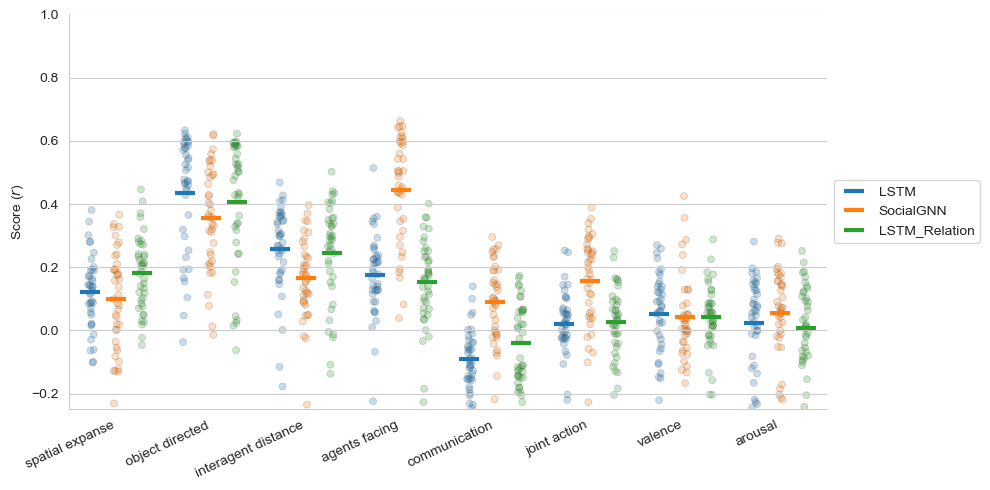

In [26]:
plot_mapping_results(ridge_results, 'ridge_beh_encoding')
plot_mapping_results(linear_results, 'linear_beh_encoding')